In [1]:
import numpy as np
import os
import h5py
import hdf5plugin
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pyrost as rst

In [2]:
!hostname

max-p3ag005.desy.de


## Processing a speckle tracking dataset from a PETRA III beamtime

For a speckle tracking dataset we need the following attributes:

- **basis_vectors** : A set of detector basis vectors for each frame of the scan. Basis vectors are comprised
  of a pair of vectors in the experimental coordinate system for slow (vertical) and fast (horizontal)
  detector axes, respectively.
- **data** : Detector images. Usually the detector images are saved into HDF5 files.
- **distance** : Sample-to-detector distance in meters.
- **translations** : Sample's translations. The translations are usually saved into the log txt files.
- **wavelength** : X-ray beam wavelength in meters.
- **x_pixel_size, y_pixel_size** : Detector pixel size along horizontal and vertical axis.

### 1. Loading log files



PETRA III P11 June 2021 beamtime

https://confluence.desy.de/display/MLL/P11+June+2021+Scan+spreadsheet

Scan 35 - Siemens star sample

`pyrost.LogProtocol` is a helper class to retrieve the data from the log files. The protocol consists of
the log keys of the attributes that are requisite to extract from the
header part of a log file and their corresponding data types:

* **datatypes** : Data type of the attributes (`float`, `int`, `str`,
  or `bool`).
* **log_keys** : Log key to find the attribute in the log file.
* **part_keys** : The name of the part where the attribute is stored in the log file.

In [3]:
scan_num = 93
log_file = f"/asap3/petra3/gpfs/p11/2023/data/11018188/raw/server_log/Scan_logs/Scan_{scan_num:d}.log"
# Creating a default protocol, and reading data from the log file
protocol = rst.LogProtocol.import_default()
log_attr = protocol.load_attributes(log_file)
log_data = protocol.load_data(log_file)
list(log_data)

['Datetime (str,None)',
 'Timestamp (float64,sec)',
 'Ifer-X [Position,Stream readout] (<type> Array,pm)',
 'Ifer-X-ref [Position,Stream readout] (<type> Array,pm)',
 'Ifer-Y [Position,Stream readout] (<type> Array,pm)',
 'Ifer-Y-ref [Position,Stream readout] (<type> Array,pm)',
 'SAM-X [Position] (int64,pm)',
 'SAM-Y [Position] (int64,pm)']

### 2. Transforming raw log data into the requisite ST attributes

Log data converter class provides an interface to read Kamzik log files
(`pyrost.KamzikConverter.read_logs`), and convert data to CXI attributes,
that can be parsed to `pyrost.STData` container.

In [4]:
# ss_vec, fs_vec - detector axes relative to the sample motor system coordinate.
# Vector magnitudes are equal to the pixel size of the detector.

fs_vec = np.array([-75e-6, 0., 0.])
ss_vec = np.array([0., -75e-6, 0.])

# Instantiating the default log data converter

kamz_conv = rst.KamzikConverter(ss_vec=ss_vec, fs_vec=fs_vec)

In [5]:
# reading data from the log file

kamz_conv = kamz_conv.read_logs(log_file)

In [6]:
# listing all the ST dataset attributes available to generate based on the log data

kamz_conv.cxi_keys()

['basis_vectors', 'sim_translations', 'log_translations']

In [7]:
# converting the log data to the basis vectors and sample translations

log_data = kamz_conv.cxi_get(['basis_vectors', 'log_translations'])
print(log_data['translations'].shape)

(36, 3)


In [8]:
# tt = log_data['translations']
# tt_x = tt[0:2601:20,0]
# tt_y = tt[0:2601:20,1]
# tt_z = tt[0:2601:20,2]
# tt_new = [tt_x,tt_y,tt_z]
# tt_new = np.reshape(tt_new,(131,3))
# print(tt.shape,tt_new.shape)
# log_data['translations'] = tt_new


# yy = log_data['basis_vectors']

# yy_new = yy[0:2601:20,:,:]
# print(yy.shape,yy_new.shape)
# log_data['basis_vectors'] = yy_new

In [9]:
# tt = log_data['translations']
# tts = (tt-np.min(tt,axis=0))/1+np.min(tt,axis=0)

# fix = lambda x: x.reshape(11,12,*x.shape[1:])[:,1:].reshape(121,*x.shape[1:])

# tts = fix(tts)


# log_data['translations'] = tts
# print(log_data['translations'].shape)
# log_data['basis_vectors'] = fix(log_data['basis_vectors'])

### 3. Loading detector frames

In [10]:
log_data['translations'].shape

(36, 3)

CXI protocol (`pyrost.CXIProtocol`) is a helper class for a `pyrost.STData`
data container, which tells it where to look for the necessary data fields in a CXI
file. The class is fully customizable so you can tailor it to your particular data
structure of CXI file. The protocol consists of the following parts for each data
attribute (`data`, `whitefield`, etc.):

* **datatypes** : Data type (`float`, `int`, `uint`, or `bool`) of the given attribute.
* **load_paths** : List of paths inside a HDF5 file, where the given data attribute may be
  saved.
* **kinds** : The attribute's kind, that specifies data dimensionality. This information
  is required to know how load, save and process the data. The attribute may be one of
  the four following kinds:

  * *scalar* : Data is either 0D, 1D, or 2D. The data is saved and loaded plainly
    without any transforms or indexing.
  * *sequence* : A time sequence array. Data is either 1D, 2D, or 3D. The data is
    indexed, so the first dimension of the data array must be a time dimension. The
    data points for the given index are not transformed.
  * *frame* : Frame array. Data must be 2D, it may be transformed with any of
    `pyrost.Transform` objects. The data shape is identical to the detector
    pixel grid.
  * *stack* : A time sequnce of frame arrays. The data must be 3D. It's indexed in the
    same way as `sequence` attributes. Each frame array may be transformed with any of
    `pyrost.Transform` objects.

In [11]:
# generating the default CXI (HDF5) file protocol and using it to find the data attributes inside the data file

data_dir = f"/asap3/petra3/gpfs/p11/2023/data/11018188/raw/scan_frames/Scan_{scan_num}/"
data_files = sorted([os.path.join(data_dir, path) for path in os.listdir(data_dir)
                    if path.endswith('.h5')])

print(data_files)

['/asap3/petra3/gpfs/p11/2023/data/11018188/raw/scan_frames/Scan_93/Scan_93_data_000001.h5', '/asap3/petra3/gpfs/p11/2023/data/11018188/raw/scan_frames/Scan_93/Scan_93_master.h5']


-4.005249999998635e-07


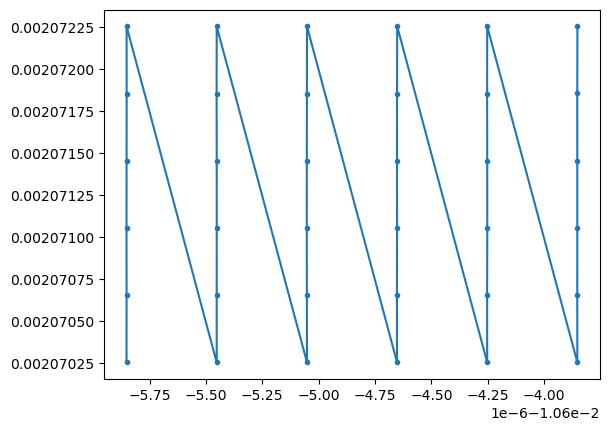

In [12]:
plt.figure()
plt.plot(log_data['translations'][:,0],log_data['translations'][:,1],'.-')
print(log_data['translations'][3,1]-log_data['translations'][4,1])

In [13]:
protocol = rst.CXIProtocol.import_default()

with h5py.File(data_files[0]) as cxi_file:
    cxi_path = protocol.find_path('data', cxi_file)
    print(cxi_path)
    print(rst.CXIProtocol.read_dataset_shapes(cxi_path, cxi_file))

/entry/data/data
{'/entry/data/data': (36, 4362, 4148)}


CXI file handler class (`pyrost.CXIStore`) accepts a set of paths to the files together with
a protocol object. `pyrost.CXIStore` searches the files for any data attributes defined by
the protocol. It provides an interface to load the data of the given attribute from the files
(see `pyrost.CXIStore.load`) and save the data of the attribute to the first file in the set
(see `pyrost.CXIStore.save`).

In [14]:
# Creating a file handler for the file

cxi_file = rst.CXIStore(data_files, 'r')

# Printing all the data attributes stored in the file

print(list(cxi_file))

# Printing a list of frame indices stored in the file

print(cxi_file.indices())

['data', 'distance', 'wavelength', 'x_pixel_size', 'y_pixel_size']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [15]:
# loading the data

with rst.CXIStore(data_files) as cxi_file:
    data = cxi_file.load_attribute('data', idxs=np.arange(36), processes=8, verbose=True)

Loading data:   0%|          | 0/36 [00:00<?, ?it/s]

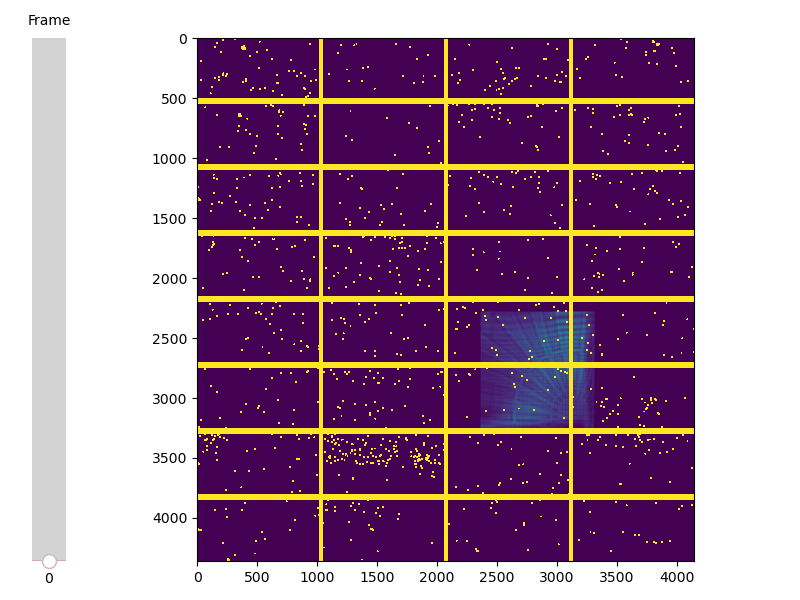

In [16]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=19,
                valstep=np.arange(0, 10),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(data[0], vmin=0.2, vmax=1000)

def update(event):
    im0.set_data(data[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

### 3. Pre-processing of a ST dataset

Transforms are common image transformations. They can be chained together using `pyrost.ComposeTransforms`.
You pass a `pyrost.Transform` instance to a data container `pyrost.STData`. 

In [17]:
roi = [2350,3250,2350,3300] 
# roi = [2000,3300,2000,3300] # a larger ROI to check infomation outside of the pupil
# roi = [2200,2800,2320,2920]  # for scan 69
transform = rst.ComposeTransforms((rst.Crop(roi), rst.Downscale(1)))

In [18]:
distance = 2.5 # meters
en_to_wl = 12398.419297617678e-10 # h * c / e [eV * m]
wavelength = en_to_wl / 17.55e3
# wavelength = 3e8*6.626e-3e4/(18.2e3)/(1.6e-19)
print(wavelength)
# Creating the main ST dataset container

st_data = rst.STData(input_file=rst.CXIStore(data_files, 'r'), \
                     transform=transform, **log_data,
                     distance=distance, wavelength=wavelength)

7.064626380408933e-11


In [19]:
# Loading detector data from the st_data.input_file

st_data = st_data.load('data', processes=8,idxs=np.arange(36))

Loading data:   0%|          | 0/36 [00:00<?, ?it/s]

Prior to performing the iterative speckle tracking reconstruction, one needs to generate the following attributes:
 - **defocus** : Focus-to-sample distance in meters
 - **white-field** : The intensity profile of the incoming X-ray beam without the sample (automatically generated if raw data frames and hot pixel masks are present inside the container).
 - **dynamic white-fields (if needed)** : A set of dynamic white-fields for each frame in the dataset.

#### 3.1. Masking out the hot pixels

In [20]:
st_data = st_data.update_mask(method='range-bad', vmax=1000000)

In [21]:
# data = (st_data.data * st_data.mask).reshape((-1, 15) + st_data.shape[-2:]).sum(axis=-3)
data = (st_data.data * st_data.mask)
data.shape

(36, 900, 950)

#### 3.2. Masking out the frames

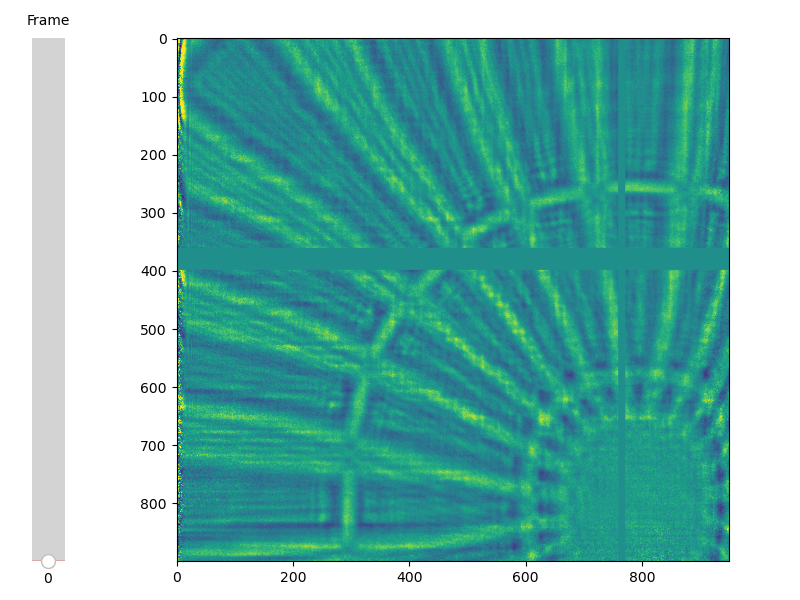

In [22]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [0.1, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=70,
                valstep=np.arange(0, 70),
                valinit=0, orientation="vertical")

cor_data = np.where(st_data.whitefield, st_data.data * st_data.mask / st_data.whitefield, 1.0)

im0 = ax[1].imshow(cor_data[0, ::1, ::1], vmin=0.2, vmax=1.8)

def update(event):
    im0.set_data(cor_data[slider.val, ::1, ::1])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

#### 3.3. Finding the defocus distance

Calculate a set of reference images for each defocus in defoci and return an average R-characteristic (local standard deviation) of an image.

In [29]:

defoci_x = np.linspace(80e-6,120e-6, 10)
defoci_y = np.linspace(80e-6,120e-6, 10)
defoci_x, defoci_y = np.meshgrid(defoci_x, defoci_y)



sweep_scan, extra = st_data.defocus_sweep(defoci_x, defoci_y, size=50, hval=1.0,
                                          extra_args={'ds_x': 3.0, 'ds_y': 3.0},
                                          return_extra=True, verbose=True)

Generating defocus sweep:   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
# reshaping the R-values into an image

sweep_scan = np.array(sweep_scan).reshape(defoci_x.shape)

In [31]:
# Finding the optimal defoci


index = np.unravel_index(np.argmax(sweep_scan), defoci_x.shape)
defocus_x, defocus_y = defoci_x[index], defoci_y[index]
print(defocus_x, defocus_y)

0.00010222222222222223 0.00010222222222222223


In [32]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(sweep_scan)
# fig.tight_layout()
# plt.show()

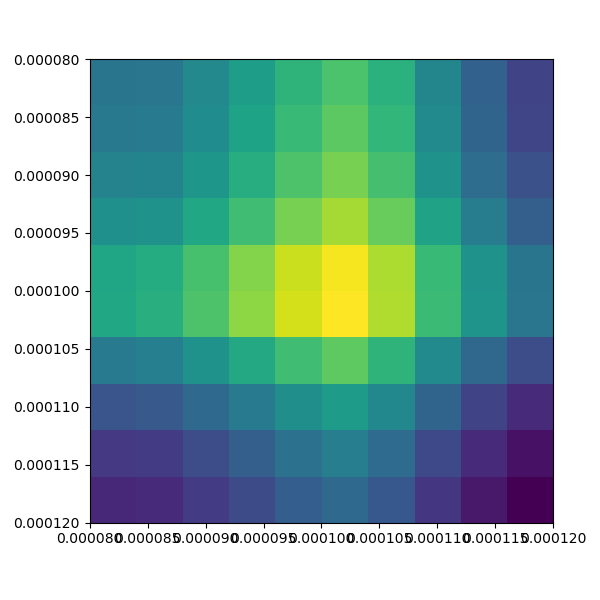

In [33]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sweep_scan, extent=[defoci_x.min(), defoci_x.max(),
                              defoci_y.max(), defoci_y.min()])
fig.tight_layout()
plt.show()

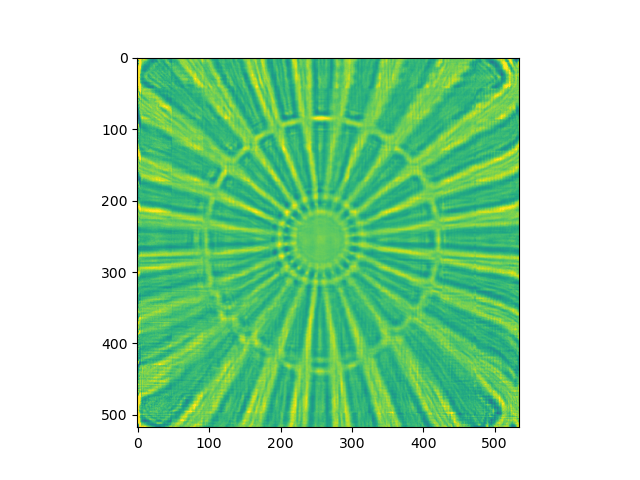

In [34]:
ref_img = extra['reference_image'][np.argmax(sweep_scan)]

%matplotlib notebook
plt.figure()
plt.imshow(ref_img,vmax=1.3)

In [35]:

st_data = st_data.update_defocus(defocus_x, defocus_y)

### 4. Performing iterative PXST reconstruction

pyrost.SpeckleTracking provides an interface to iteratively refine the reference image and lens wavefront.
It offers two methods to choose from:

* `pyrost.SpeckleTracking.train` : performs the iterative reference image
  and pixel mapping updates with the constant kernel bandwidths for the reference image
  estimator (`h0`).

* `pyrost.SpeckleTracking.train_adapt` : does ditto, but updates the bandwidth
  value for the reference image estimator at each iteration by the help of the BFGS method
  to attain the minimal error value.

In [36]:
# generating a speckle tracking "reconstructer"
# ds_x, ds_y - sampling intervals of the reference image in pixels

st_obj = st_data.get_st(ds_x=3.0, ds_y=3.0, ff_correction=True)

In [37]:
# finding the optimal reference image bandwidth
#
# kernel bandwidth used in the reference image reconstruction,
# the higher it is the blurrier the image is
#
# The cross validation error is minimized when the kernel bandwidth is "right"
# CV -> https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75

h_vals = np.linspace(0.3, 4.0, 25)
cv_vals = st_obj.CV_curve(h_vals)

Calculating CV:   0%|          | 0/25 [00:00<?, ?it/s]

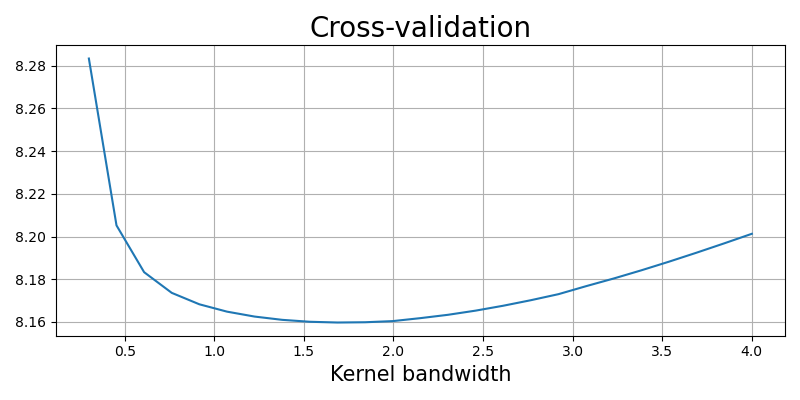

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(h_vals, cv_vals)
ax.set_xlabel('Kernel bandwidth', fontsize=15)
ax.set_title('Cross-validation', fontsize=20)
ax.tick_params(labelsize=10)
ax.grid(True)
fig.tight_layout()
plt.show()

#### Performing the reconstruction

`pyrost.SpeckleTracking` provides an interface to perform the reference image and lens wavefront
reconstruction and offers two methods:

1. **`pyrost.SpeckleTracking.train`** - iterative update with the static bandwidth
2. **`pyrost.SpeckleTracking.train_adapt`** - iterative update with the adpatively updated bandwidth

The typical reconstruction cycle consists of:

* Estimating an optimal kernel bandwidth for the reference image estimate (`pyrost.SpeckleTracking.find_hopt`,
  in `pyrost.SpeckleTracking.train_adapt` only).
* Generating the reference image (`pyrost.SpeckleTracking.update_reference`).
* Updating the discrete (pixel) mapping between a stack of frames and the generated reference image
  (`pyrost.SpeckleTracking.update_pixel_map`).
* Updating the sample translations vectors (`pyrost.SpeckleTracking.update_translations`).
* Calculating figures of merit (`pyrost.SpeckleTracking.ref_total_error`,
  `pyrost.SpeckleTracking.error_profile`).
  
`pyrost.SpeckleTracking.train_adapt` parameters:
- `search_window` : A tuple of three elements ('sw_y', 'sw_x', 'sw_s'). The elements are the following:

    * `sw_y` : Search window size in pixels along the horizontal detector axis.
    * `sw_x` : Search window size in pixels along the vertical detector axis.
    * `sw_s` : Search window size of the Huber scaling map. Given as a ratio (0.0 - 1.0) relative to the scaling map value before the update.

- `h0` : Initial kernel bandwidth used in `reference_image` estimation. The value is given in pixels.
- `blur` : Smoothing kernel bandwidth used in `pixel_map` regularisation. The value is given in pixels.
- `n_iter` : Maximum number of iterations.

In [47]:
h0 = h_vals[np.argmin(cv_vals)]

# performing the PXST reconstruction with adaptive bandwidth
# performing the update first with high 'blur' value to supress any artifacts in pixel_map

# more info -> https://robust-speckle-tracking.readthedocs.io/en/latest/reference/rst_ref.html

st_adapt = st_obj.train_adapt(search_window=(10.0, 10.0, 0.1), h0=h0, blur=32.0, n_iter=1,
                              pm_method='rsearch', pm_args={'n_trials': 75})

   0%            Iteration 0 / 1 [00:00<?, ?it/s]

Initial error = 40.708644, Initial h0 = 1.69


In [48]:
# performing the fine update with lower 'blur' value

st_adapt = st_adapt.train_adapt(search_window=(5.0, 5.0, 0.1), h0=h0, blur=32.0, n_iter=1,
                                pm_method='rsearch', pm_args={'n_trials': 75})

   0%            Iteration 0 / 1 [00:00<?, ?it/s]

Initial error = 37.852146, Initial h0 = 1.69


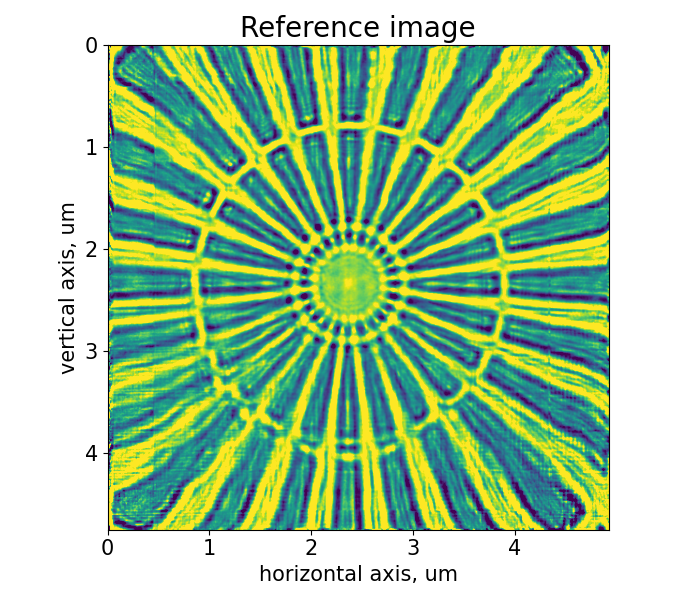

In [49]:
# Plotting the reconstructed reference image
# All the blurriness has to be corrected after the update
ref_dx = (st_adapt.ds_x * st_data.x_pixel_size * st_data.defocus_x / st_data.distance).item() * 1e6
ref_dy = (st_adapt.ds_y * st_data.y_pixel_size * st_data.defocus_y / st_data.distance).item() * 1e6

fig, ax = plt.subplots(figsize=(7, 6))
ax.imshow(st_adapt.reference_image, vmin=0.8, vmax=1.1,
          extent=[0, st_adapt.reference_image.shape[1] * ref_dx,
                  st_adapt.reference_image.shape[0] * ref_dy, 0])
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis, um', fontsize=15)
ax.set_ylabel('vertical axis, um', fontsize=15)
ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()

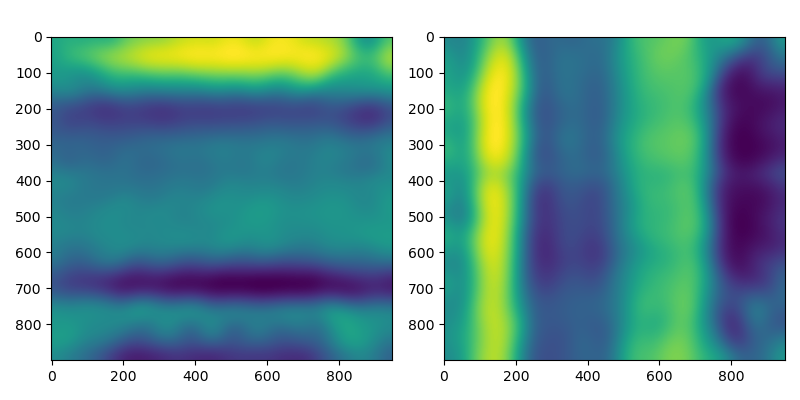

In [51]:
# Plotting the reconstructed pixel_map
# You expect to see a smooth profile with following the third polynomial

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((st_adapt.pixel_map[0] - st_obj.pixel_map[0]))
ax[1].imshow((st_adapt.pixel_map[1] - st_obj.pixel_map[1]))
fig.tight_layout()
plt.show()

### 4. Phase reconstruction

We got the pixel mapping from the detector plane to the reference plane, which can
be easily translated to the angular displacement profile of the lens. One can reconstruct
the lens' phase profile with `pyrost.STData.import_st` method. Besides, one can fit the phase
profile with a polynomial function using `pyrost.AberrationsFit` fitter object,
which can be obtained with `pyrost.STData.get_fit` method.

In [52]:
# Generating a phase out of st_adapt.pixel_map
# The phase is saved into st_data.phase

st_data.import_st(st_adapt)

In [53]:
# Fitting the phase profile with st_data.get_fit
# axis - 0 for y axis and 1 for x axis

fit_obj_ss = st_data.get_fit(axis=0)
fit_ss = fit_obj_ss.fit(max_order=3)
fit_obj_fs = st_data.get_fit(axis=1)
fit_fs = fit_obj_fs.fit(max_order=3)
print(fit_fs['c_3'], fit_fs['c_4'], fit_ss['c_3'], fit_ss['c_4'])

0.04088798005905029 -0.0007530144730399749 0.02479458318561443 -0.00042308637721589153


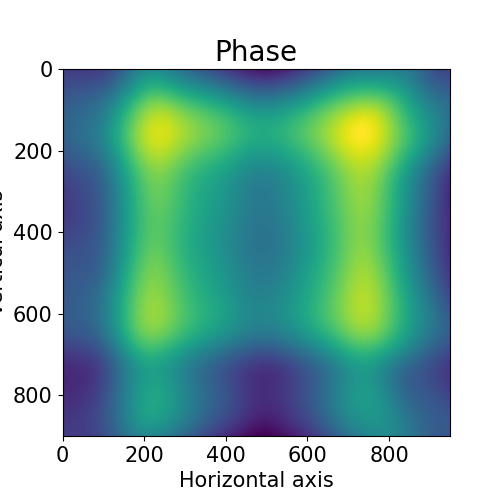

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(st_data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('Horizontal axis', fontsize=15)
ax.set_ylabel('Vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.show()

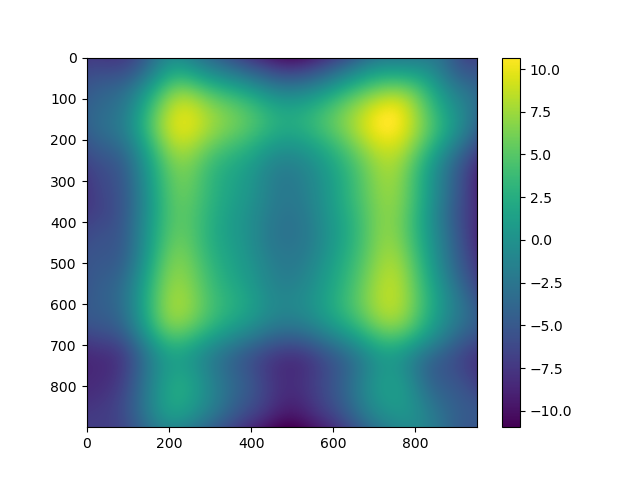

In [55]:
%matplotlib notebook
plt.figure()
plt.imshow(st_data.get('phase'))
plt.colorbar()

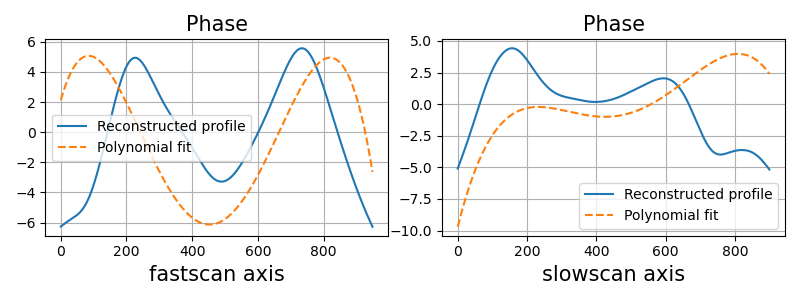

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.phase, label='Reconstructed profile')
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.model(fit_fs['ph_fit']), linestyle='dashed',
                 label='Polynomial fit')
axes[0].set_xlabel('fastscan axis', fontsize=15)
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.phase, label='Reconstructed profile')
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.model(fit_ss['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[1].set_xlabel('slowscan axis', fontsize=15)
for ax in axes:
    ax.set_title('Phase', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=10)
    ax.grid(True)
fig.tight_layout()
plt.show()

In [57]:
phase = st_data.get('phase')
average_phase = np.mean(phase)
RMS = np.sqrt(np.mean(phase**2)-average_phase**2)
print(RMS)

4.463276071579388


In [58]:
average_phase

-3.4039567785653453e-17

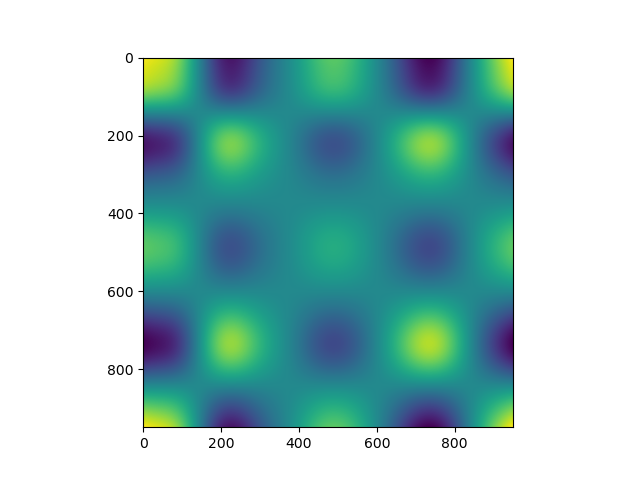

In [60]:
phase_x = fit_obj_fs.phase
phase_y = fit_obj_ss.phase
phase = np.outer(phase_x,phase_x)

plt.figure()
plt.imshow(phase)